In [1]:
rv = sp.stats.norm(loc=10, scale=10)

In [ ]:
xx = xx = np.linspace(-40, 60, 1000)
pdf = rv.pdf

In [ ]:
sns.distplot(rv.rvs(size=10000, random_state=1))

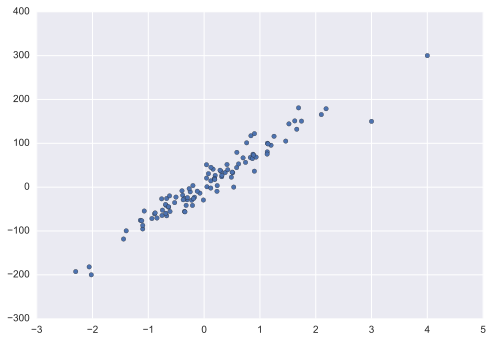

In [2]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20, coef=True, random_state=1)

# add high-leverage points
X0 = np.vstack([X0, np.array([[4],[3]])])
X = sm.add_constant(X0)
y = np.hstack([y, [300, 150]])
plt.scatter(X0, y)
plt.show()

In [3]:
model = sm.OLS(pd.DataFrame(y), pd.DataFrame(X))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1464.
Date:                Thu, 28 Jul 2016   Prob (F-statistic):           1.61e-61
Time:                        11:43:38   Log-Likelihood:                -452.71
No. Observations:                 102   AIC:                             909.4
Df Residuals:                     100   BIC:                             914.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              3.2565      2.065      1.577      0.1

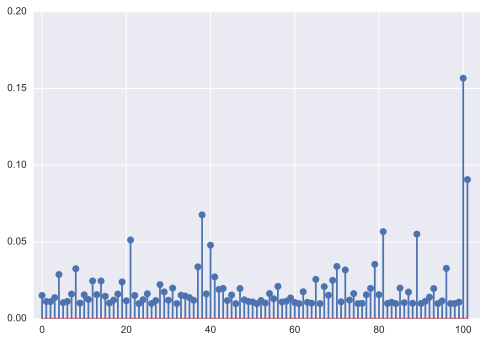

hat.sum() = 2.0


In [4]:
influence = result.get_influence()
hat = influence.hat_matrix_diag
plt.stem(hat)
plt.axis([ -2, len(y)+2, 0, 0.2 ])
plt.show()
print("hat.sum() =", hat.sum())

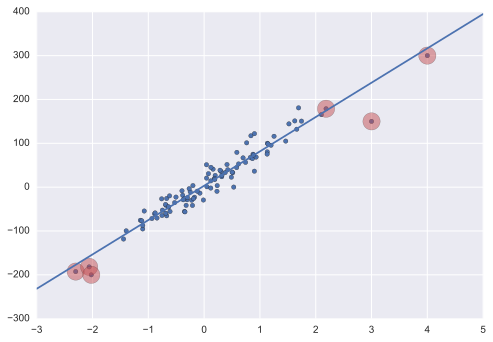

In [5]:
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, ax=plt.gca())

idx = hat > 0.05
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
plt.axis([-3, 5, -300, 400])
plt.show()

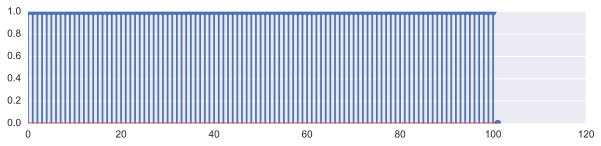

In [6]:
plt.figure(figsize=(10, 2))
plt.stem(result.outlier_test().ix[:, -1])
plt.show()

In [7]:
import pandas_datareader.data as wb

symbols = ['AAPL', 'MSFT', 'YHOO', 'DB', 'GLD']
noa = len(symbols)
data = pd.DataFrame()
for sym in symbols:
    data[sym] = wb.DataReader(sym, data_source='yahoo',
                              end='2014-09-12')['Adj Close']
data.columns = symbols
data.tail()

,AAPL,MSFT,YHOO,DB,GLD
Date,,,,,
2014-09-08,95.195338,44.324409,41.810001,34.039067,120.730003
2014-09-09,94.837239,44.601017,40.779999,33.834365,120.870003
2014-09-10,97.750397,44.677325,41.139999,34.399735,120.260002
2014-09-11,98.166562,44.829937,41.259998,34.360744,119.470001
2014-09-12,98.389165,44.543790,42.880001,34.146292,118.379997


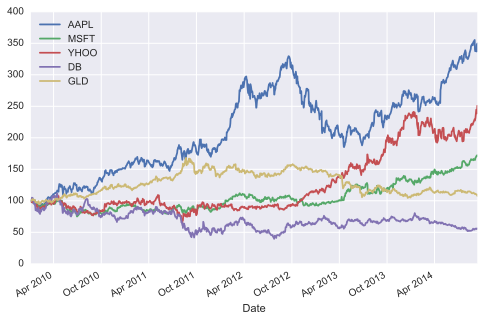

In [8]:
(data / data.ix[0] * 100).plot(figsize=(8, 5), grid=True)
plt.show()

In [9]:
rets = np.log(data / data.shift(1))
rets.mean() * 252

AAPL    0.267080
MSFT    0.114505
YHOO    0.196165
DB     -0.125174
GLD     0.016054
dtype: float64

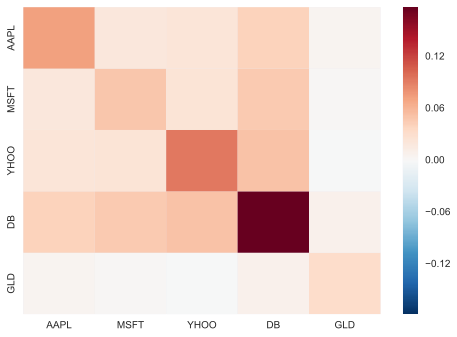

In [10]:
sns.heatmap(rets.cov() * 252)
plt.show()

In [11]:
np.random.seed(2)
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.23349275,  0.01388454,  0.2943663 ,  0.2331326 ,  0.22512381])

In [12]:
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(rets.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

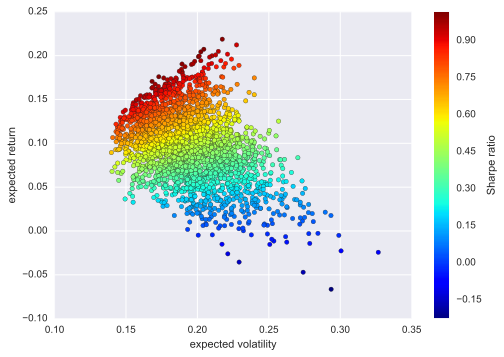

In [13]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [14]:
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        포트폴리오 내의 증권 비중
    
    Returns
    =======
    pret : float
        포트폴리오 수익률의 기댓값
    pvol : float
        포트폴리오 변동성의 기댓값
    pret / pvol : float
        무위험 이자율이 0일 때의 포트폴리오 샤프 지수
    '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])


In [15]:
import scipy.optimize as sco

In [16]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [17]:
# constraint
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

In [18]:
# bound constraint
bnds = tuple((0, 1) for x in range(noa))
bnds

((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

In [19]:
noa * [1. / noa,]

[0.2, 0.2, 0.2, 0.2, 0.2]

In [20]:
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [21]:
opts
# Success True 확인해야 함.  최소점 못 찾는 경우 있음

     fun: -1.0630084836647968
     jac: array([ -1.82956457e-04,  -7.02306628e-04,   7.18027353e-04,
         1.51409824e+00,   1.54869258e-03,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([  6.61851745e-01,   8.64634631e-02,   2.51684792e-01,
         0.00000000e+00,   3.84878219e-16])

In [22]:
opts['x'].round(3)

array([ 0.662,  0.086,  0.252,  0.   ,  0.   ])

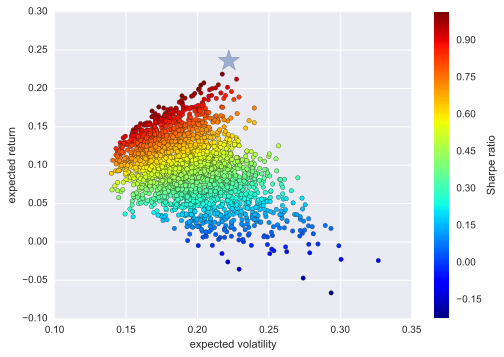

In [23]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5)
plt.show()

In [29]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [30]:
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

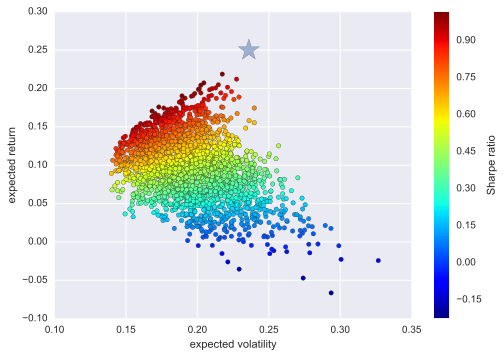

In [35]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_optv = statistics(optv['x']).round(3)
plt.scatter(pt_optv[1], pt_optv[0], marker="*", s=500, alpha=0.5)
plt.show()

In [32]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [33]:
def min_func_port(weights):
    return statistics(weights)[1]

In [34]:
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

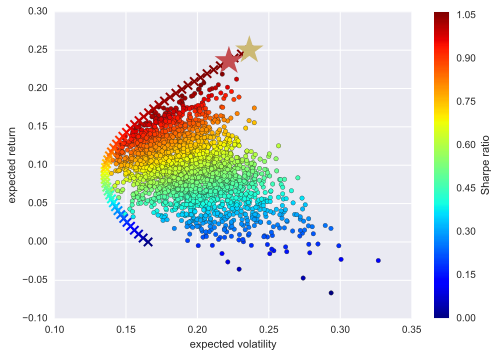

In [31]:
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o', cmap=mpl.cm.jet)
            # 무작위 포트폴리오
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x', s=70, linewidth=2, cmap=mpl.cm.jet)
            # 효율적 투자선
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=30)
            # 최대 샤프 지수를 가진 포트폴리오
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=30)
            # 최소 분산 포트폴리오
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()